# TMA4212 - Numerical Solution of Differential Equations by Difference Methods
## Exercise 3 
Aksel Stenvold, Casper Lindeman & Gonchigsuren Bor

**1a)** In this exercise we want to solve the problem with artificial B.C's with central differences in space and Crank-Nicolson in time. 

In [1]:
#used libraries
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

In [2]:
B = np.array([[-18,0],[0,20]])
print(np.linalg.eigvals(B))

[-18.  20.]


In [3]:
#defining a class for IBVP. Taken from previous exercise.
class IBVP(object): 
    def __init__(self, ga=0, gb=0, a=0, b=5*np.pi, u0=0, f=0):
        self.ga = ga       # left boundary condition
        self.gb = gb       # right boundary condition
        self.a = a         # left boundary position 
        self.b = b         # right boundary position 
        self.u0 = u0       # initial condition
        self.f = f         # right hand side 

In [4]:
#plotting function taken from exercise 2
def plot_solution(x, t, U, txt='Solution'):
    
    fig, ax = plt.subplots(figsize = (10,10), subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt)

In [5]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [6]:
'''''
The function tridiag_changed takes in
    - x: an array with the discretized values for the x-axis
    - sigma: volatility/standard error
    - r: interest rates
    - c: correlation
    - k: time step
    - h: spacial step
It returns a tridiagonal matrix A, that is the matrix that we will use for the CN scheme to solve the Black-Scholes equation.
'''''

def tridiag_changed(x, sigma, r, c, k, h):
    # Help function 
    x_v = x[2:-1]
    v = k*sigma**2*x_v**2/(4*h**2) - k*r*(x_v)/(4*h) #lower diagonal of A

    x_diag =  x[1:-1]
    diag = -k*sigma**2*x_diag**2/(2*h**2) - c*k/2 #diagonal of A
    
    x_w = x[1:-2]
    w = k*sigma**2*x_w**2/(4*h**2) + k*r*x_w/(4*h) #lower diagonal of A

    A = np.diag(v, -1) + np.diag(diag) + np.diag(w, 1)
    return A

In [7]:
'''''
The code below is the implementation of the Crank-Nicholson scheme on the Black-Scholes equation. It takes in 
    - IBVP: a class with the initial and boundary conditions
    - sigma: volatility
    - r: interest rates
    - c: correlation
    - M: number of steps in x-direction
    - N: number of steps in time
    - T: time
The function returns a discrete version of the x- and t-axis as well as an (M+1)x(N+1) matrix U which contains the numerial solution of the Black-Scholes equation using the Crank-Nicholson
scheme. 
'''''
def CN(IBVP, sigma = 0.5, r = 0.0556, c = 0.06, M = 100, N = 100, T = 1):
    h = (IBVP.b - IBVP.a)/M
    k = T/N
    x = np.linspace(IBVP.a, IBVP.b, M+1) #gridpoints on x-axis
    t = np.linspace(0, T, N+1) #gridpoints on y-axis

    U = np.zeros((M+1, N+1))
    g = np.zeros((M-1, N+1))

    K1 = k*sigma**2/(4*h**2)
    K2 = k*r/(4*h)

    K_diff = K1*x[1]**2 - K2*x[1]
    K_sum = K1*x[-2]**2 + K2*x[-2]

    g[0] = K_diff * IBVP.ga(0, t)
    g[-1] = K_sum * IBVP.gb(IBVP.b, t)

    I = tridiag(0, 1, 0, M-1) #identity matrix
    A = tridiag_changed(x, sigma, r, c, k, h) #A matrix

    U[:,0] = IBVP.u0(x, 0) #initial condition
    U[0] = IBVP.ga(0, t) #boundary condition
    U[-1] = IBVP.gb(IBVP.b, t) #boundary condition

    for n in range(N):
        LHS = (I+A)@U[1:-1, n] + g[:,n+1]+g[:,n] + 0.5*k*(IBVP.f(x[1:-1], t[n+1])+IBVP.f(x[1:-1], t[n])) #Left hand side of the equation
        U[1:-1, n+1] = np.linalg.solve(I-A, LHS)

    return x, t, U

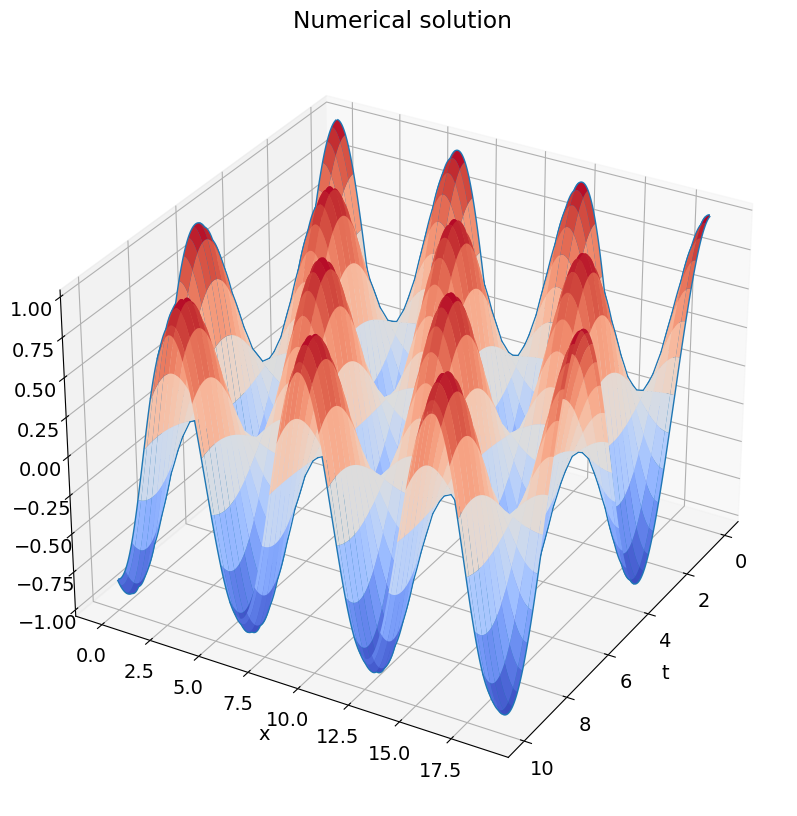

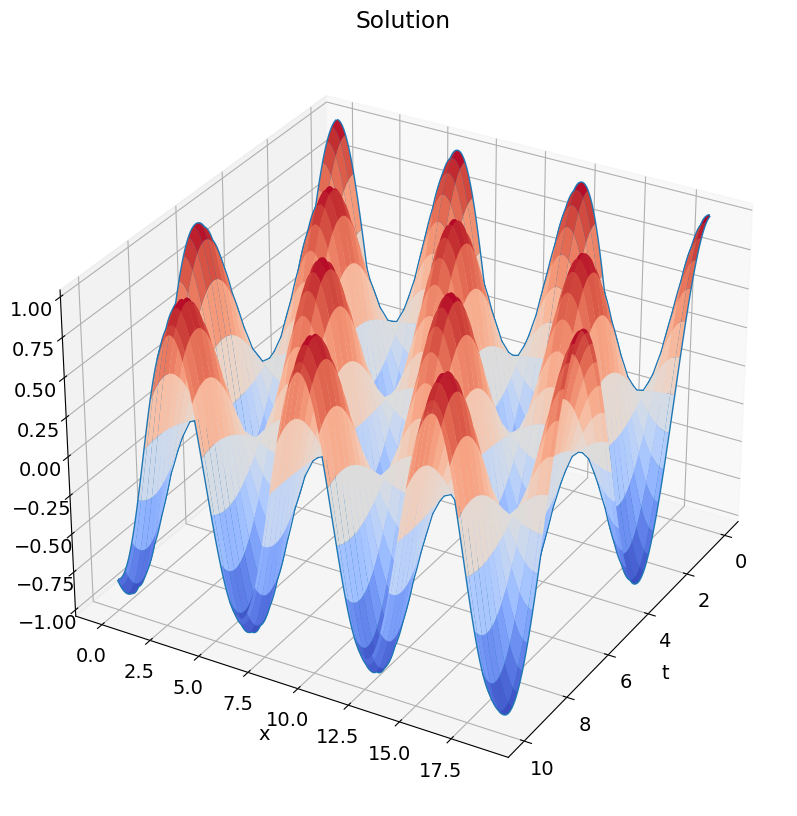

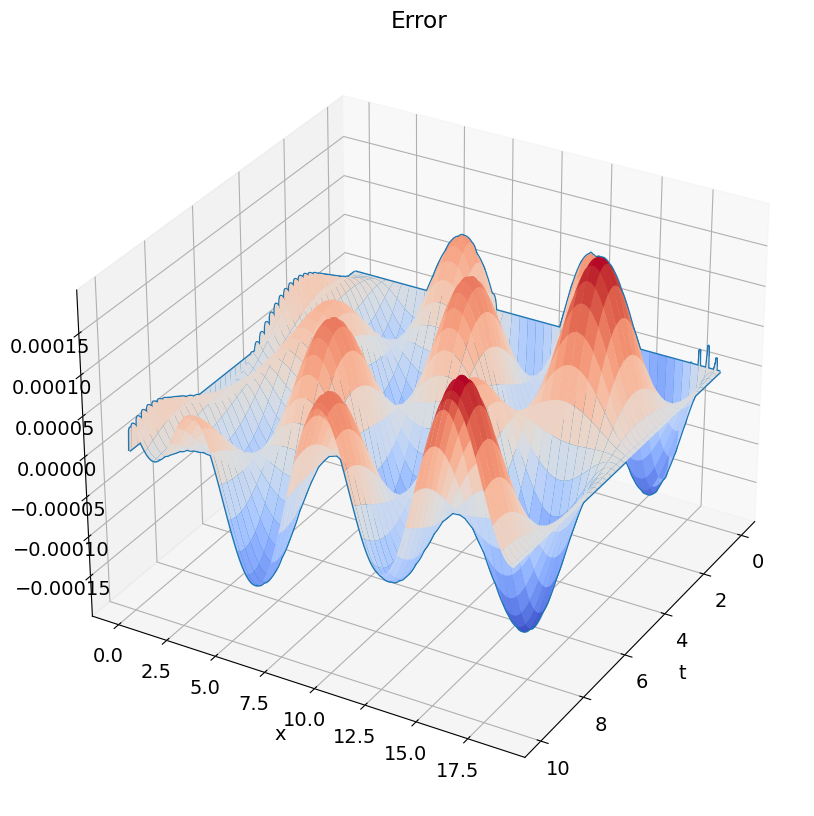

In [8]:
#global variables
T = 10 #time
M = 500 #steps in x-direction
N = 500 #steps in time
r = 0.05 #interest rate
sigma = 0.5 #volatility
c = 0.15 #correlation
K = 120 #strike price

#initial and boundary conditions used for the scheme
def g0(x,t): 
    return np.cos(t)*np.cos(x)

def g1(x,t): 
    return np.cos(t)*np.cos(x)

def func(x,t): 
    k1 = 0.5*sigma**2*x**2
    k2 = r*x
    return  -np.sin(t)*np.cos(x) + k1*np.cos(t)*np.cos(x) + k2*np.cos(t)*np.sin(x) + c*np.cos(t)*np.cos(x)

def initial_cond(x,t):    
    return np.cos(t)*np.cos(x)

def exact_solution(x,t):
    return np.cos(t)*np.cos(x)

#numerical solution
ibvp = IBVP(g0, g1, 0, 6*np.pi, initial_cond, func)
x, t, U = CN(ibvp, sigma, r, c, M, N, T)
plot_solution(x, t, U, txt='Numerical solution')

#exact solution
t_mesh, x_mesh = np.meshgrid(t,x)
solution = exact_solution(x_mesh,t_mesh)
plot_solution(x, t, solution)

#plottiing the error
plot_solution(x, t, U-solution, txt='Error')

**1e)**



`convergence_space` calcualtes the error and converngece for the error when $M$ gets doubled.

In [9]:
def convergence_space(u_exact,heat_object, solver=CN): 
    P = 6
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 10
    
    T=10
    N=1000
    r = 0.05
    sigma = 0.5
    c = 0.15
    K=120

    for p in range(P):
        ibvp = IBVP(g0, g1, 0, 6*np.pi, initial_cond,func)
        x, t, U = CN(ibvp, sigma, r, c, M, N, T)

        t_mesh, x_mesh = np.meshgrid(t,x)
        solution = exact_solution(x_mesh,t_mesh)
        
        Eh = solution-U
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))

        M *= 2
        
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

In [10]:
H, E, p = convergence_space(exact_solution, ibvp)
import pandas as pd #To format the output of the notebook.  
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': H, 'Error': E ,'Rate':Rate})
print("Table with step-size (space), error and the convergence rate")
df

Table with step-size (space), error and the convergence rate


,h,Error,Rate
0,1.88495559,0.48055996,0.00000000
1,0.94247780,0.12502204,1.94253394
2,0.47123890,0.03022374,2.04842824
3,0.23561945,0.00755842,1.99952582
4,0.11780972,0.00188572,2.00296946
5,0.05890486,0.00047164,1.99936253


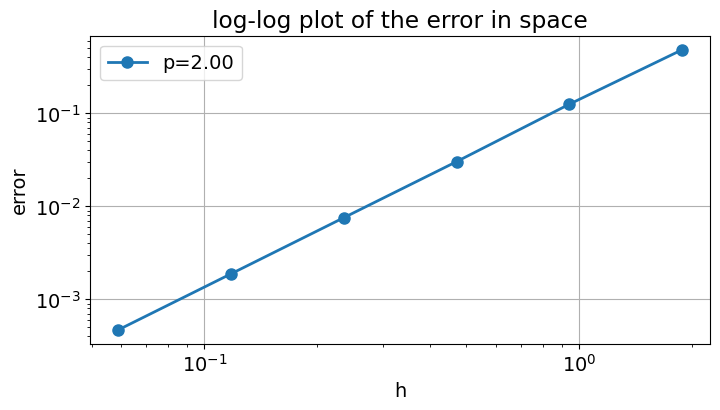

In [11]:
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("log-log plot of the error in space")
plt.legend()

`convergence_time` calcualtes the error and converngece for the error when $N$ gets doubled.

In [12]:
def convergence_time(u_exact,heat_object, solver=CN): 
    P = 6
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 1000

    T=10
    N=10
    r = 0.05
    sigma = 0.5
    c = 0.15
    K=120
    for p in range(P):
        
        ibvp = IBVP(g0, g1, 0, 6*np.pi, initial_cond,func)
        x, t, U = CN(ibvp, sigma, r, c, M, N, T)

        t_mesh, x_mesh = np.meshgrid(t,x)
        solution = exact_solution(x_mesh,t_mesh)
        
        Eh = solution-U
        Hconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
    
        N *= 2
        
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

In [13]:
T, E, p = convergence_time(exact_solution, ibvp) 

Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(T[1:]/T[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': T, 'Error': E ,'Rate':Rate}) 
print("Table with step-size (time), error and the convergence rate")
df

Table with step-size (time), error and the convergence rate


,h,Error,Rate
0,1.00000000,0.13565296,0.00000000
1,0.50000000,0.03344149,2.02020930
2,0.25000000,0.00833139,2.00500967
3,0.12500000,0.00208926,1.99556420
4,0.06250000,0.00052223,2.00024035
5,0.03125000,0.00013057,1.99985123


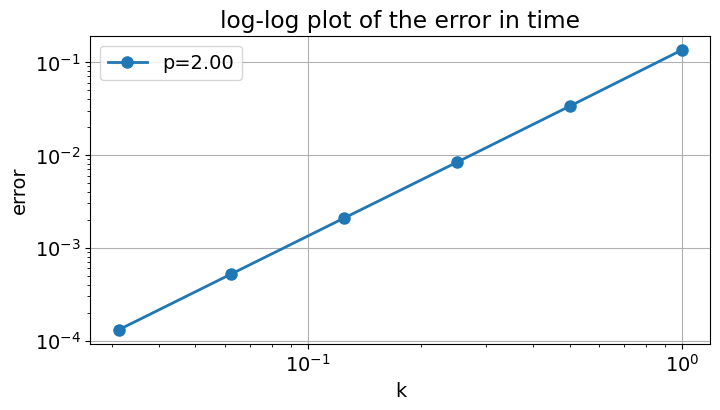

In [14]:
plt.loglog(T,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('k')
plt.ylabel('error')
plt.title("log-log plot of the error in time")
plt.legend();

**1f)**

In [15]:
T=10
M=100
N=100
sigma = 0.5
c = 0.15
K=20

r = 2*K
M0 = M

M_array = np.linspace(100,300, 101)
R_array = np.linspace(100,300, 101)


P = 5
R = np.zeros(P)
error = np.zeros(P)

for i in range(P):
    ibvp = IBVP(g0, g1, 0, r, initial_cond,func)
    x, t, U = CN(ibvp, sigma, r, c, M, N, T)

    t_mesh, x_mesh = np.meshgrid(t,x)
    solution = exact_solution(x_mesh,t_mesh)
    
    Eh = solution-U
    
    R[i] = 2**i
    error[i] = np.max(np.abs(Eh[:M0,:]))
    
    M *=2
    r *=2

pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'R=a*K': R, 'Error': error}) 
print("Table with errors within x=[0,a*K]. A being the number in the first column")
df

Table with errors within x=[0,a*K]. A being the number in the first column


,R=a*K,Error
0,1.00000000,0.09632246
1,2.00000000,0.07588854
2,4.00000000,0.12655065
3,8.00000000,0.10491679
4,16.00000000,0.10485211


In [16]:
T=10
M=100
N=100
sigma = 0.5
c = 0.15
K=20

r = 2*K
M0 = M

P = 5
R = np.zeros(P)
error = np.zeros(P)

for i in range(P):
    ibvp = IBVP(g0, g1, 0, r, initial_cond,func)
    x, t, U = CN(ibvp, sigma, r, c, M, N, T)

    t_mesh, x_mesh = np.meshgrid(t,x)
    solution = exact_solution(x_mesh,t_mesh)
    
    Eh = solution-U
    
    R[i] = 2**i
    error[i] = np.max(np.abs(Eh[:M0,:]))
    
    M *=2
    r *=2

pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'R=a*K': R, 'Error': error}) 
print("Table with errors within x=[0,a*K]. A being the number in the first column")
df

Table with errors within x=[0,a*K]. A being the number in the first column


,R=a*K,Error
0,1.00000000,0.09632246
1,2.00000000,0.07588854
2,4.00000000,0.12655065
3,8.00000000,0.10491679
4,16.00000000,0.10485211
